# Vehicle Detection and Tracking Project

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import sklearn
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

## Data loading and exploration
Here we read in training data for our classifier, and explore the properties of data.

There are  8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


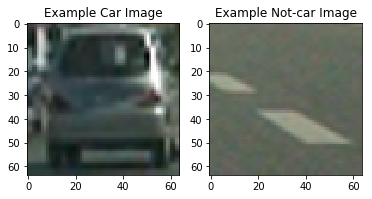

In [2]:
## Load data
## Load training data from udaciy dataset
images = glob.glob('training_data/*/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Sample the data for development. Use whole set during training.
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

# Randoemly show images in dataset.
def random_show_dataset():  
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')

random_show_dataset()

# Extract data properties.
def get_data_dict(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_dict = get_data_dict(cars, notcars)

print('There are ', data_dict["n_cars"], ' cars and', 
      data_dict["n_notcars"], ' non-cars')
print('of size: ',data_dict["image_shape"], ' and data type:', 
      data_dict["data_type"])

## Feature extractions
In this part, we prepare functions to extract features from images. 

In [3]:

## Functions to extract various features.

# Color histogram
# Define a function to compute color histogram features  
def color_hist(image, nbins=32, bins_range=(0, 256), vis=False):
    '''Compute the histogram of the RGB channels separately
       Concatenate the histograms into a single feature vector
       Return the feature vector
    '''
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
    
    # Concatenate the histograms into a single feature vector
    #feature size should be 96
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    #print("color_hist feature size:", len(hist_features)) 
        
    #Visualization    
    if vis == True:
        # Generating bin centers
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, rhist[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, ghist[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, bhist[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
    return hist_features

# Define a function that takes an image and a new image size
# and returns a feature vector
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel()

def get_cspace_image(image, color_space='RGB'):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    
    return feature_image

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True): 
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    feature_image = get_cspace_image(img, color_space) 
       
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        file_features.append(single_img_features(image, color_space, spatial_size, hist_bins,
                                           orient, pix_per_cell, cell_per_block, hog_channel,
                                           spatial_feat, hist_feat, hog_feat))    
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

## Test block for feature extraction functions

In [4]:
## Test feature fuctions

# A function to show an image
def show_img(img):
    if len(img.shape)==3:
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.figure()
        plt.imshow(img, cmap='gray')

def test_bin_spatial():
    car_ind = np.random.randint(0, len(cars))
    car_image = mpimg.imread(cars[car_ind])
    
    features = bin_spatial(car_image)
    
#test_bin_spatial()

def test_color_hist():
    car_ind = np.random.randint(0, len(cars))
    car_image = mpimg.imread(cars[car_ind])
    
    test_img = car_image #mpimg.imread('./test_images/test1.jpg')
    color_hist(test_img, vis=True)

def test_cspace_convertion():
    car_ind = np.random.randint(0, len(cars))
    car_image = mpimg.imread(cars[car_ind])
    
    test_img = car_image #mpimg.imread('./test_images/test1.jpg')
    out_img = get_cspace_image(test_img, color_space='YUV')
    show_img(out_img)
    
#test_cspace_convertion()

def test_hog_features():
    car_ind = np.random.randint(0, len(cars))
    car_image = mpimg.imread(cars[car_ind])
    
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel=0

    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(car_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=True)

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')

#test_hog_features()

def test_single_img_features():
    car_ind = np.random.randint(0, len(cars))
    car_image = mpimg.imread(cars[car_ind])
    
    features = single_img_features(car_image)
    print("single img feature size: ", len(features))

#test_single_img_features()
    

## Train the classifier

In [5]:
# Parameters to tweek
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# Verify input
print("Number of car images: ", len(cars))
print("Number of notcar images: ", len(notcars))

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Car features: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Notcar features: ', len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=20)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Number of car images:  8792
Number of notcar images:  8968


/home/lindong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car features:  8792
Notcar features:  8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
9.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9778


[ 0.]


/home/lindong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


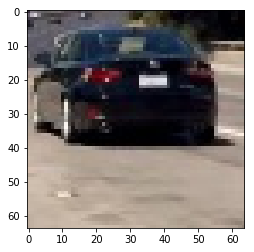

In [7]:
cropped_image = cv2.imread('cropped.jpg')
show_img(cropped_image)
cropped_features = single_img_features(cropped_image, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                     orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
#5) Scale extracted features to be fed to classifier
cropped_test_features = X_scaler.transform(np.array(cropped_features).reshape(1, -1))
#6) Predict using your classifier
prediction = svc.predict(cropped_test_features)
print(prediction)

## Sliding window functions
In the part, we prepare the functions that performs sliding window.

In [ ]:
## Sliding window implementation
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    #set default value for start/stop if not specified
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    
    x_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    y_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    x_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    y_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    x_windows_num = np.int((x_span-x_buffer)/x_step) 
    y_windows_num = np.int((y_span-y_buffer)/y_step) 
    
    window_list = []
    for ys in range(y_windows_num):
        for xs in range(x_windows_num):
            # Calculate window position
            startx = xs*x_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*y_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# test sliding window
def test_slide_window():
    image = mpimg.imread('./test_images/test1.jpg')
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(150, 150), xy_overlap=(0.8, 0.8))
    
    window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
    show_img(window_img)
    
test_slide_window()

## Search window and classifier test
In the part, we implement a search window and apply classifier on the image.

In [ ]:
y_start_stop = [400, 600]

def search_windows(img, windows, clf, scaler, color_space='YUV', 
                    spatial_size=(32, 32), hist_bins=16, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    cnt = 0
    for window in windows:
        cnt += 1
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if cnt == 29:
            prediction = 1
            show_img(test_img)
            cv2.imwrite('cropped.jpg', test_img)
        if prediction == 1:
            on_windows.append(window)
        
    #8) Return windows for positive detections
    return on_windows

image = cv2.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
            xy_window=(150, 150), xy_overlap=(0.8, 0.8))

hot_windows = []
hot_windows += search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

show_img(window_img)


In [ ]:
cropped_image = cv2.imread('cropped.jpg')
show_img(cropped_image)
cropped_features = single_img_features(cropped_image, color_space='YUV', 
                    spatial_size=(32, 32), hist_bins=16, 
                     orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
#5) Scale extracted features to be fed to classifier
cropped_test_features = X_scaler.transform(np.array(cropped_features).reshape(1, -1))
#6) Predict using your classifier
prediction = svc.predict(cropped_test_features)
print(prediction)